In [79]:
import sys
import os
import copy

# Absolute path to your module's directory
module_path = os.path.abspath('/localscratch/zippoema/git/HPA/src/')
if module_path not in sys.path:
    sys.path.insert(0, module_path)

import hpa.cluster as hpacl  # Now this should work
import hpa.util as hpau  # Now this should work
import hpa.plots as hpapl

In [80]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import gsd.hoomd 
from MDAnalysis.analysis import distances



In [81]:
path_drop = '/localscratch/zippoema/project_ness/simulations/droplet_200-tdp43-lcd/'
path_slab = '/localscratch/zippoema/project_ness/simulations/slab_200-tdp43-lcd/'
path = '/localscratch/zippoema/project_ness/simulations/'
path_ss = '/localscratch/zippoema/project_ness/simulations/no_pser_mass_method/phase_diagram/search_steadystate/'
path_work = '/localscratch/zippoema/working_dir/'
path_an_drop = '/localscratch/zippoema/project_ness/analysis/droplet_200-tdp43-lcd/'
path_struct = '/localscratch/zippoema/project_ness/simulations/condensate_structure/'
path_ness = '/localscratch/zippoema/project_ness/simulations/cycle_ness/simple-ness_pp3_masspSer/'
path_fix = '/localscratch/zippoema/project_ness/simulations/cycle_ness/ness_ck1d_pp3_masspSer/'

### Center trajectory

In [39]:
hpau.center_trajectory_z(path_struct+'sim_eq_400-tdp43-lcd_slab/sim_eq_400-tdp43-lcd-2301pser_CAL3_slab_dump.gsd',
                         path_struct+'sim_eq_400-tdp43-lcd_slab/sim_eq_400-tdp43-lcd-2301pser_CAL3_slab_dump_centered.gsd',
                         group=[i for i in range(61600)], cluster=True, cutoff=2.5)

hpau.center_trajectory_z(path_struct+'sim_eq_400-tdp43-lcd_slab/sim_eq_400-tdp43-lcd_CAL3_slab_dump.gsd',
                         path_struct+'sim_eq_400-tdp43-lcd_slab/sim_eq_400-tdp43-lcd_CAL3_slab_dump_centered.gsd',
                         group=[i for i in range(61600)], cluster=True, cutoff=2.5)


Centering trajectory along z: 100%|███████████████████████████████████| 500/500 [00:45<00:00, 10.96it/s]


In [36]:
hpau.center_trajectory_z(path_struct+'sim_eq_slab_150-full-tdp43_5-pp3/sim_eq_slab_150-com-full-tdp43_5-com-pp3_CAL3_dump.gsd',
                         path_struct+'sim_eq_slab_150-full-tdp43_5-pp3/sim_eq_slab_150-com-full-tdp43_5-com-pp3_CAL3_dump_centered.gsd',
                         group=[i for i in range(61600)], cluster=True, cutoff=2.5)

hpau.center_trajectory_z(path_struct+'sim_eq_slab_150-full-tdp43_5-pp3/sim_eq_slab_150-com-full-tdp43-922pser_5-com-pp3_CAL3_dump.gsd',
                         path_struct+'sim_eq_slab_150-full-tdp43_5-pp3/sim_eq_slab_150-com-full-tdp43-922pser_5-com-pp3_CAL3_dump_centered.gsd',
                         group=[i for i in range(61600)], cluster=True, cutoff=2.5)
                       

Centering trajectory along z: 100%|█████████████████████████████████| 2500/2500 [03:43<00:00, 11.19it/s]


In [83]:
for i in range(2,4):
    hpau.center_trajectory(path_drop+f'sim_oscillation_200-tdp43-lcd_2-ck1d-open_10-pp3/sim{i}_200-tdp43-lcd_2-com-ck1d-open_10-com-pp3_CAL3_osc_dump.gsd', 
                           path_drop+f'sim_oscillation_200-tdp43-lcd_2-ck1d-open_10-pp3/sim{i}_200-tdp43-lcd_2-com-ck1d-open_10-com-pp3_CAL3_osc_dump_centered.gsd', 
                           group=[i for i in range(30800)], cluster=True, cutoff=2.5)

Centering trajectory: 100%|█████████████████████████████████████████| 5000/5000 [06:44<00:00, 12.37it/s]


In [84]:
for i in range(1,4):
    hpau.center_trajectory(path_drop+f'sim_ness_200-tdp43-lcd_2-ck1d-open_12-pp3/sim{i}_ness_200-tdp43-lcd_2-com-ck1d-open_12-com-pp3_CAL3_dump.gsd', 
                           path_drop+f'sim_ness_200-tdp43-lcd_2-ck1d-open_12-pp3/sim{i}_ness_200-tdp43-lcd_2-com-ck1d-open_12-com-pp3_CAL3_dump_centered.gsd', 
                           group=[i for i in range(30800)], cluster=True, cutoff=2.5)

Centering trajectory: 100%|█████████████████████████████████████████| 4000/4000 [05:24<00:00, 12.34it/s]


### Unwrap trajectory

In [10]:
traj_in = gsd.hoomd.open('/localscratch/zippoema/project_ness/analysis/compute_diffusion_dilute/sim_single-tdp43-lcd/sim_p-tdp43_dump.gsd', 'rb')
traj_out = gsd.hoomd.open('/localscratch/zippoema/project_ness/analysis/compute_diffusion_dilute/sim_single-tdp43-lcd/sim_p-tdp43_dump_unwrapped.gsd', 'wb')

for frame in tqdm(traj_in):
    # Copy the frame to preserve all other information
    new_frame = gsd.hoomd.Frame()
    new_frame.configuration = frame.configuration
    new_frame.particles = frame.particles

    # Box dimensions
    Lx, Ly, Lz = frame.configuration.box[:3]

    # Unwrap positions using image flags
    pos = frame.particles.position.copy()
    image = frame.particles.image.copy()   # integer triplets
    pos[:, 0] += image[:, 0] * Lx
    pos[:, 1] += image[:, 1] * Ly
    pos[:, 2] += image[:, 2] * Lz

    # Store unwrapped positions
    new_frame.particles.position = pos

    # Write to output
    traj_out.append(new_frame)

traj_out.close()

### Modify particle positions

In [12]:
for i in [1]:
    frame_pos = gsd.hoomd.open(path_work+'search_steadystate/search_200-tdp43-lcd_2-ck1d-open_10-pp3/sim1_200-tdp43-lcd-2000pSer_2-com-ck1d-open_10-com-pp3_CAL3_search_end.gsd', mode='rb')[0]
    frame_compl = gsd.hoomd.open(path_work+'search_steadystate/search_200-tdp43-lcd_2-ck1d-open_12-pp3/sim1_200-tdp43-lcd-2000pSer_2-com-ck1d-open_12-com-pp3_CAL3_search_start.gsd', mode='rb')[0]
    hpau.modify_particles_position(frame_compl, frame_pos, id_init_pos=0, id_end_pos=36654, 
                                   save=path_work+'search_steadystate/search_200-tdp43-lcd_2-ck1d-open_12-pp3/sim1_200-tdp43-lcd-2000pSer_2-com-ck1d-open_12-com-pp3_CAL3_search_start1.gsd')


In [13]:
frame_pos = gsd.hoomd.open(path_work+'search_steadystate/search_200-tdp43-lcd_2-ck1d-open_10-pp3/sim1_200-tdp43-lcd-2000pSer_2-com-ck1d-open_10-com-pp3_CAL3_search_end.gsd', mode='rb')[0]
frame_compl = gsd.hoomd.open(path_work+'search_steadystate/search_200-tdp43-lcd_2-ck1d-open_12-pp3/sim1_200-tdp43-lcd-2000pSer_2-com-ck1d-open_12-com-pp3_CAL3_search_start1.gsd', mode='rb')[0]

hpau.modify_particles_typeid(frame_compl, frame_pos, id_init_tid=0, id_end_tid=30800,
                               save=path_work+'search_steadystate/search_200-tdp43-lcd_2-ck1d-open_12-pp3/sim1_200-tdp43-lcd-2000pSer_2-com-ck1d-open_12-com-pp3_CAL3_search_start.gsd')


In [25]:
frame_pos = gsd.hoomd.open(path_struct+'equilibrium/sim_eq_slab_400-tdp43-lcd_5-ck1d-open/sim_eq_slab_400-tdp43-lcd_5-com-ck1d-open_CAL3_start.gsd', mode='rb')[0]
frame_compl = gsd.hoomd.open(path_work+'condensate_struct_CAL3/sim_eq_slab_400-tdp43-lcd_5-pp3/sim_eq_slab_400-tdp43-lcd_5-com-pp3_CAL3_start_lattice.gsd', mode='rb')[0]
snap = copy.deepcopy(frame_compl)
snap.configuration = frame_pos.configuration
tdp43_cond_n = 154*400
'''
snap.particles.typeid[:tdp43_cond_n] = frame_pos.particles.typeid[:tdp43_cond_n]
snap.particles.charge[:tdp43_cond_n] = frame_pos.particles.charge[:tdp43_cond_n]
snap.particles.mass[:tdp43_cond_n] = frame_pos.particles.mass[:tdp43_cond_n]
'''
snap.particles.velocity[:tdp43_cond_n] = frame_pos.particles.velocity[:tdp43_cond_n]
snap.particles.image[:tdp43_cond_n] = frame_pos.particles.image[:tdp43_cond_n]

snap.particles.position[:tdp43_cond_n] = frame_pos.particles.position[:tdp43_cond_n]
snap.particles.position[:tdp43_cond_n,2] -= np.mean(frame_pos.particles.position[:tdp43_cond_n,2], axis=0)
pp3_pos = snap.particles.position[tdp43_cond_n:]
for npp3 in range(5):
    pp3_pos[527*npp3:527*(npp3+1)] -= np.mean(frame_compl.particles.position[tdp43_cond_n+527*npp3:tdp43_cond_n+527*(npp3+1)], axis=0)
    pp3_pos[527*npp3:527*(npp3+1)] += np.array([-(-1)**npp3*(npp3%3)*4, (-1)**npp3*(npp3%2)*6, -(-1)**npp3*(37+npp3*7)])

snap.particles.position[tdp43_cond_n:] = pp3_pos

with gsd.hoomd.open(path_work+'condensate_struct_CAL3/sim_eq_slab_400-tdp43-lcd_5-pp3/shtherm_eq_slab_400-tdp43-lcd_5-com-pp3_CAL3_start.gsd', mode='wb') as f:
    f.append(snap)


In [67]:
for i in [2500]:
    frame_compl = gsd.hoomd.open(path_work+f'search_steadystate/init_search_200-tdp43-lcd_2-ck1d-open_10-pp3/sim1_200-tdp43-lcd_2-com-ck1d-open_10-com-pp3_CAL3_lattice.gsd', mode='rb')[0]
    frame_pos = gsd.hoomd.open(path_work+f'search_steadystate/init_search_200-tdp43-lcd_2-ck1d-open_10-pp3/sim1_200-tdp43-lcd-{i}pSer_5-ck1d-open_hps-cp-r30.gsd', mode='rb')[0]
    hpau.modify_particles_position(frame_compl, frame_pos, id_end_compl=30800, id_end_pos=30800,
                                   save=path_work+f'search_steadystate/init_search_200-tdp43-lcd_2-ck1d-open_10-pp3/sim1_200-tdp43-lcd-{i}pSer_2-com-ck1d-open_10-com-pp3_CAL3_shorttherm_start.gsd')

In [42]:
for i in [2500]:
    frame_pos = gsd.hoomd.open(path_work+'no_driving_slab/sim_eq_slab_200-tdp43-lcd_2-ck1d-open_10-pp3/sim1_eq_slab_200-tdp43-lcd_2-com-ck1d-open_10-com-pp3_CAL3_dump.gsd', mode='rb')[-1]
    frame_compl = gsd.hoomd.open('/localscratch/zippoema/project_ness/analysis/compute_diffusion_dilute/sim_single-tdp43-lcd/snap_p-tdp43_start.gsd', mode='rb')[0]
    hpau.modify_particles_typeid(frame_compl, frame_pos, id_init_tid=18634, id_end_tid=18787,
                                   save='/localscratch/zippoema/project_ness/analysis/compute_diffusion_dilute/sim_single-tdp43-lcd/sim_p-tdp43_start.gsd')

## Create distance trajectory

In [55]:
153+92

245

100%|█████████████████████████████████████████████████████████| 400000/400000 [04:10<00:00, 1599.41it/s]


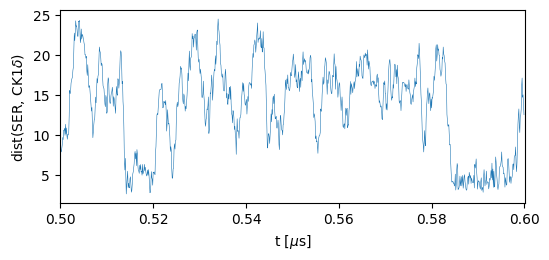

100%|█████████████████████████████████████████████████████████| 400000/400000 [03:49<00:00, 1740.02it/s]


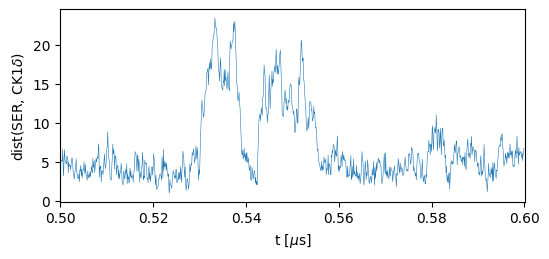

100%|█████████████████████████████████████████████████████████| 400000/400000 [03:49<00:00, 1746.40it/s]


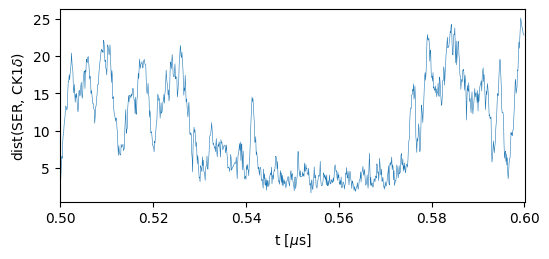

100%|█████████████████████████████████████████████████████████| 400000/400000 [03:52<00:00, 1719.06it/s]


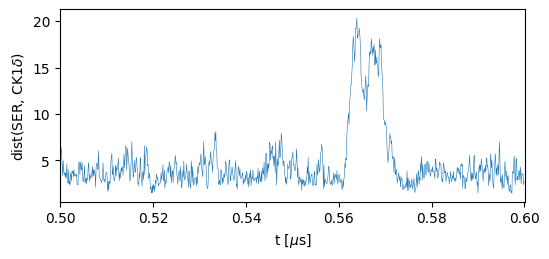

100%|█████████████████████████████████████████████████████████| 400000/400000 [03:52<00:00, 1721.65it/s]


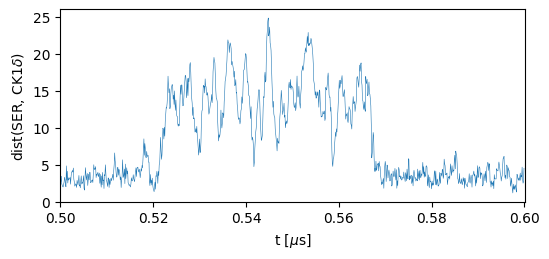

In [82]:
rdump = '5k'
ck1d_bool = False
pp3_bool = True
dmu = '-2.5'
time = '20us_'

if ck1d_bool and pp3_bool:
    enzymes = '1-ck1d-open_1-pp3'
    enzfile = 'com-ck1d-open_com-pp3'
    temp = '200K_'
    suffix = 'sp_repel_mpSer_rs'
    pt = path_fix+f'sim_ser19_dmu{dmu}_1-tdp43-5pser_{enzymes}_{suffix}/'
    ck1d_ids = [300,301,302]
    pp3_ids = [445+92,445+94,445+120,445+152,445+283]
elif ck1d_bool:
    enzymes = '1-ck1d-open'
    enzfile = 'com-ck1d-open'
    temp = 'CAL3_200K_'
    suffix = 'mpSer_rs'
    pt = path_ness+f'sim_ser19_dmu{dmu}_1-tdp43-5pser_{enzymes}_200K_{rdump}_{suffix}/'
    enz_ids = [300,301,302]
elif pp3_bool:
    enzymes = '1-pp3'
    enzfile = 'com-pp3'
    temp = 'CAL3_200K_'
    suffix = 'mpSer_rs'
    pt = path_ness+f'sim_ser19_dmu{dmu}_1-tdp43-5pser_{enzymes}_200K_{rdump}_{suffix}/'
    enz_ids = [153+92,153+94,153+120,153+152,153+283]   
else:
    RaiseError('no enzymes!')

for s in range(1,6):
    if ck1d_bool and pp3_bool:
        d = hpau.create_distance_file(pt+f'sim{s}_ser19_dmu{dmu}_1-tdp43-5pser_{enzfile}_{temp}{rdump}_{suffix}_{time}dump.gsd', 
                                         id1=ck1d_ids, id2=[i for i in range(154)], mean1=True, therm=0)
        tmp = hpau.create_distance_file(pt+f'sim{s}_ser19_dmu{dmu}_1-tdp43-5pser_{enzfile}_{temp}{rdump}_{suffix}_{time}dump.gsd', 
                                         id1=pp3_ids, id2=[i for i in range(154)], mean1=True, therm=0)
        d = np.append(d, tmp, axis=1)
    else:
        d = hpau.create_distance_file(pt+f'sim{s}_ser19_dmu{dmu}_1-tdp43-5pser_{enzfile}_{temp}{rdump}_{suffix}_{time}dump.gsd', 
                                         id1=enz_ids, id2=[i for i in range(154)], mean1=True, therm=0)
    
    np.savetxt(pt+f'sim{s}_ser19_dmu{dmu}_1-tdp43-5pser_{enzfile}_{temp}{rdump}_{suffix}_{time}dist.txt', d)
    hpapl.plot_dist(d,part_id=5,start=5000,end=6000)

In [ ]:
!ls /localscratch/zippoema/project_ness/simulations/cycle_ness/ness_ck1d_pp3_masspSer/sim_ser19_dmu-5_0_1-tdp43-5pser_1-ck1d-open_1-pp3_sp_repel_mpSer_rs/sim1_ser19_dmu-5_0_1-tdp43-5pser_com-ck1d-open_com-pp3_200K_5k_sp_repel_mpSer_rs_10us_contacts.txt

100%|██████████████████████████████████████████████████████████| 200000/200000 [03:59<00:00, 833.42it/s]


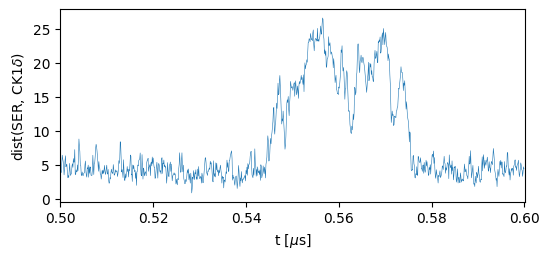

100%|█████████████████████████████████████████████████████████| 200000/200000 [02:26<00:00, 1367.59it/s]


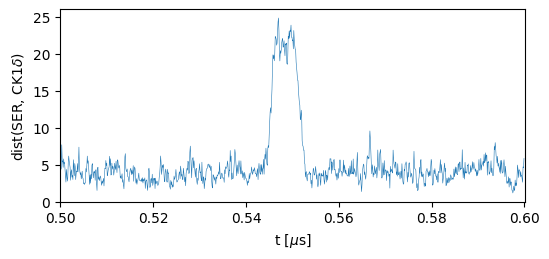

100%|█████████████████████████████████████████████████████████| 200000/200000 [02:52<00:00, 1160.62it/s]


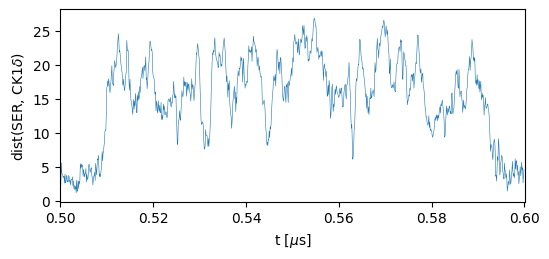

In [25]:
for s in range(1,4):
    d = hpau.create_distance_file(path_fix+f'sim_ser19_dmu-5_+2.5_1-tdp43-5pser_1-ck1d-open_1-pp3_sp_repel_mpSer_rs/sim{s}_ser19_dmu-5_+2.5_1-tdp43-5pser_com-ck1d-open_com-pp3_200K_5k_sp_repel_mpSer_rs_dump.gsd', 
                                         id1=[300,301,302], id2=[i for i in range(154)], mean1=True, therm=0)
    tmp = hpau.create_distance_file(path_fix+f'sim_ser19_dmu-5_+2.5_1-tdp43-5pser_1-ck1d-open_1-pp3_sp_repel_mpSer_rs/sim{s}_ser19_dmu-5_+2.5_1-tdp43-5pser_com-ck1d-open_com-pp3_200K_5k_sp_repel_mpSer_rs_dump.gsd', 
                                         id1=[445+92,445+94,445+120,445+152,445+283], id2=[i for i in range(154)], mean1=True, therm=0)
    d = np.append(d, tmp, axis=1)
    np.savetxt(path_fix+f'sim_ser19_dmu-5_+2.5_1-tdp43-5pser_1-ck1d-open_1-pp3_sp_repel_mpSer_rs/sim{s}_ser19_dmu-5_+2.5_1-tdp43-5pser_com-ck1d-open_com-pp3_200K_5k_sp_repel_mpSer_rs_dist.txt', d)
    hpapl.plot_dist(d,part_id=5,start=5000,end=6000)

100%|█████████████████████████████████████████████████████████| 200000/200000 [00:42<00:00, 4654.27it/s]


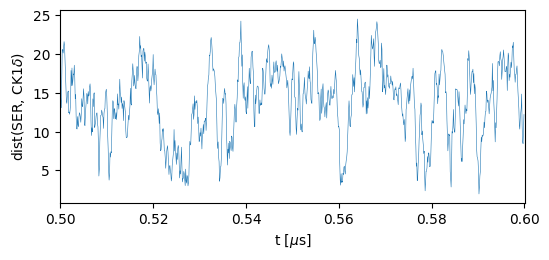

100%|█████████████████████████████████████████████████████████| 200000/200000 [01:00<00:00, 3325.35it/s]


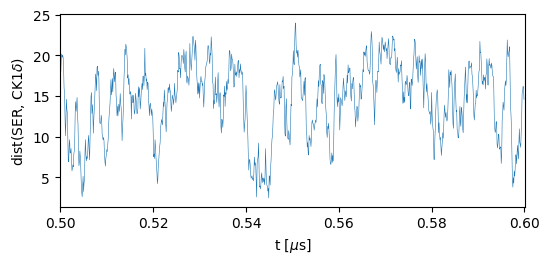

100%|█████████████████████████████████████████████████████████| 200000/200000 [00:39<00:00, 5035.83it/s]


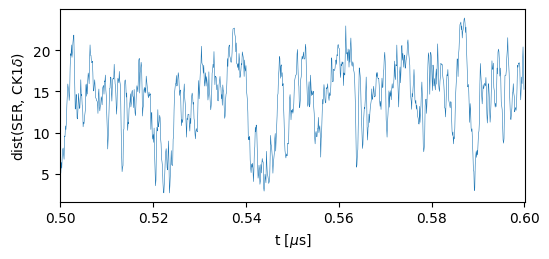

100%|█████████████████████████████████████████████████████████| 200000/200000 [00:41<00:00, 4788.33it/s]


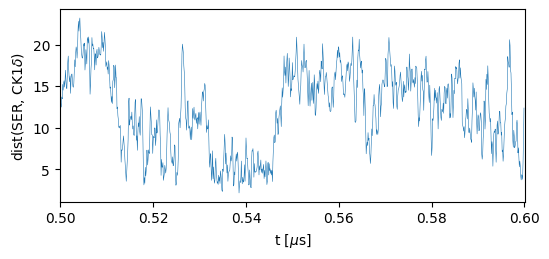

100%|█████████████████████████████████████████████████████████| 200000/200000 [00:39<00:00, 5019.90it/s]


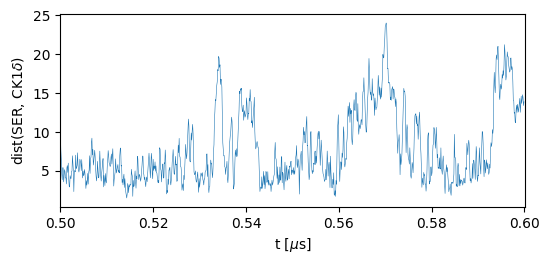

100%|█████████████████████████████████████████████████████████| 200000/200000 [00:40<00:00, 4917.04it/s]


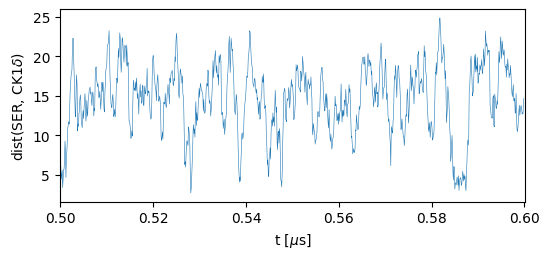

100%|█████████████████████████████████████████████████████████| 200000/200000 [01:00<00:00, 3280.36it/s]


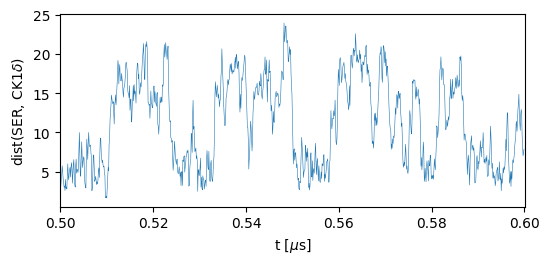

100%|█████████████████████████████████████████████████████████| 200000/200000 [00:42<00:00, 4752.80it/s]


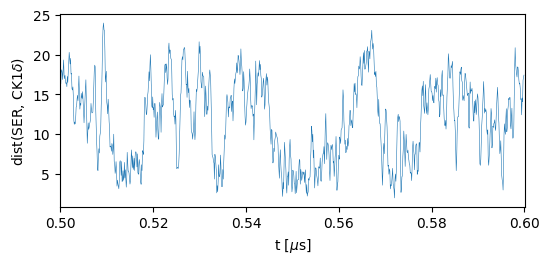

100%|█████████████████████████████████████████████████████████| 200000/200000 [00:40<00:00, 4915.90it/s]


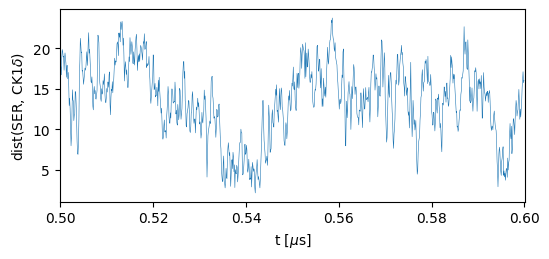

100%|█████████████████████████████████████████████████████████| 200000/200000 [00:38<00:00, 5193.38it/s]


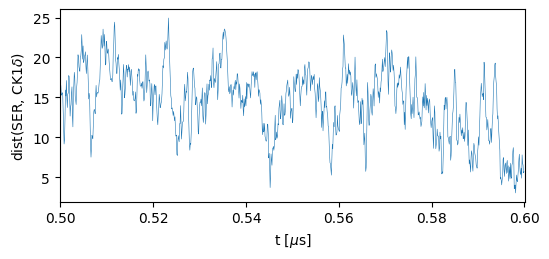

In [7]:
rdump = 5
rigid = 'rigid-'
dmu = 15
path_mc = f'/localscratch/zippoema/working_dir/tests/test_MC_kinetic/'
for s in range(11,21):
    d = hpau.create_distance_file(path_mc+f'sim_ser19_dmu-{dmu}_1-tdp43-5pser_1-{rigid}ck1d-open_{rdump}k_MCkin/sim{s}_ser19_dmu-{dmu}_1-tdp43-5pser_com-{rigid}ck1d-open_CAL3_{rdump}k_MCkin_dump.gsd', 
                                     id1=[300,301,302], id2=[i for i in range(154)], mean1=True, therm=0)
    np.savetxt(path_mc+f'sim_ser19_dmu-{dmu}_1-tdp43-5pser_1-{rigid}ck1d-open_{rdump}k_MCkin/sim{s}_ser19_dmu-{dmu}_1-tdp43-5pser_com-{rigid}ck1d-open_CAL3_{rdump}k_MCkin_dist.txt', d)
    hpapl.plot_dist(d,part_id=5,start=5000,end=6000)

100%|█████████████████████████████████████████████████████████████████████████| 400000/400000 [01:40<00:00, 3970.63it/s]


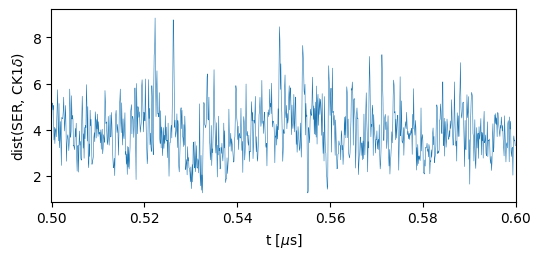

In [8]:
pt_mc = '/localscratch/zippoema/project_ness/simulations/simple-ness_ck1d_MC_kin/'
d = hpau.create_distance_file(pt_mc+f'sim_ser19_dmu-5_1-tdp43-5pser_1-ck1d-open_200K_5k_MC_kin/sim5_ser19_dmu-5_1-tdp43-5pser_com-ck1d-open_CAL3_200K_5k_MC_kin_dump.gsd', 
                                     id1=[300,301,302], id2=[i for i in range(154)], mean1=True, therm=0)
np.savetxt(pt_mc+f'sim_ser19_dmu-5_1-tdp43-5pser_1-ck1d-open_200K_5k_MC_kin/sim5_ser19_dmu-5_1-tdp43-5pser_com-ck1d-open_CAL3_200K_5k_MC_kin_dist.txt', d)
hpapl.plot_dist(d,part_id=5,start=5000,end=6000)